In [3]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"

FILE = PROCESSED_DIR / "crime_and_punishment_clean.json"

with open(FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

data.keys(), type(data['chapters'])

(dict_keys(['book', 'chapters']), list)

In [4]:
rows = []

for ch_idx, chapter in enumerate(data["chapters"], start = 1):
    for seg_idx, seg_text in enumerate(chapter):
        rows.append({
            "chapter": ch_idx,
            "segment": seg_idx,
            "text": seg_text
        })

df = pd.DataFrame(rows)
df.head()

,chapter,segment,text
0,1,0,CHAPTER I
1,1,1,On an exceptionally hot evening early in July ...
2,2,0,CHAPTER II
3,2,1,"Raskolnikov was not used to crowds, and, as we..."
4,3,0,CHAPTER III


In [5]:
import re
sent_rows = []

for _, row in df.iterrows():
    sentences = re.split(r"(?<=[.!?])\s+", row["text"].strip())
    for i, sent in enumerate(sentences):
        sent = sent.strip()
        if not sent:
            continue
        sent_rows.append({
            "chapter": row["chapter"],
            "segment": row["segment"],
            "sent_in_segment": i,
            "sentence": sent
        })

df_sent = pd.DataFrame(sent_rows)
df_sent.head()

,chapter,segment,sent_in_segment,sentence
0,1,0,0,CHAPTER I
1,1,1,0,On an exceptionally hot evening early in July ...
2,1,1,1,"Place and walked slowly, as though\nin hesitat..."
3,1,1,2,bridge.
4,1,1,3,He had successfully avoided meeting his landla...


In [6]:
characters = {
    "Raskolnikov": [
        "Raskolnikov", "Rodion", "Rodion Romanovich"
    ],
    "Sonya": [
        "Sonya", "Sonia", "Sofya Semyonovna"
    ],
    "Porfiry": [
        "Porfiry", "Porfiry Petrovich"
    ],
    "Dunya": [
        "Dunya", "Avdotya Romanovna"
    ],
    "Svidrigailov": [
        "Svidrigaïlov", "Arkady Ivanovich"
    ],
    "Luzhin": [
        "Luzhin", "Pyotr Petrovich"
    ],
    "Marmeladov": [
        "Marmeladov", "Semyon Zakharovich"
    ]
}


In [7]:
def count_mentions(sentence, aliases):
    s = sentence.lower()
    return sum(s.count(alias.lower()) for alias in aliases)

for char, aliases in characters.items():
    df_sent[char] = df_sent['sentence'].apply(lambda s: count_mentions(s, aliases))



In [8]:
mention_counts = df_sent[list(characters.keys())].sum().sort_values(ascending=False)
mention_counts

Raskolnikov     883
Sonya           464
Svidrigailov    211
Porfiry         206
Luzhin          113
Dunya           102
Marmeladov       42
dtype: int64

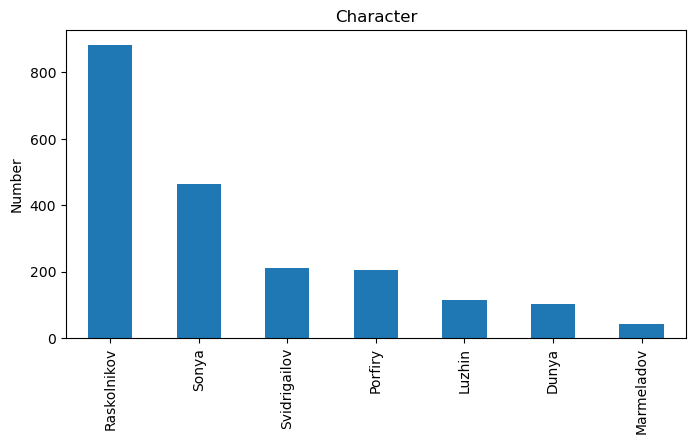

In [9]:
plt.figure(figsize=(8,4))
mention_counts.plot(kind="bar")
plt.title("Crime and Punishment - Character Mentions")
plt.ylabel("Number")
plt.title("Character")
plt.savefig(BASE_DIR / "plots" / "cnp_character_mentions.png", dpi=300)
plt.show()

In [10]:
df_sent.head()

,chapter,segment,sent_in_segment,sentence,Raskolnikov,Sonya,Porfiry,Dunya,Svidrigailov,Luzhin,Marmeladov
0,1,0,0,CHAPTER I,0,0,0,0,0,0,0
1,1,1,0,On an exceptionally hot evening early in July ...,0,0,0,0,0,0,0
2,1,1,1,"Place and walked slowly, as though\nin hesitat...",0,0,0,0,0,0,0
3,1,1,2,bridge.,0,0,0,0,0,0,0
4,1,1,3,He had successfully avoided meeting his landla...,0,0,0,0,0,0,0


In [11]:
df_sent["present_characters"] = df_sent.apply(
    lambda row: [c for c in characters.keys() if row[c] > 0],
    axis = 1
)

df_sent.head()

,chapter,segment,sent_in_segment,sentence,Raskolnikov,Sonya,Porfiry,Dunya,Svidrigailov,Luzhin,Marmeladov,present_characters
0,1,0,0,CHAPTER I,0,0,0,0,0,0,0,[]
1,1,1,0,On an exceptionally hot evening early in July ...,0,0,0,0,0,0,0,[]
2,1,1,1,"Place and walked slowly, as though\nin hesitat...",0,0,0,0,0,0,0,[]
3,1,1,2,bridge.,0,0,0,0,0,0,0,[]
4,1,1,3,He had successfully avoided meeting his landla...,0,0,0,0,0,0,0,[]


In [12]:
import itertools
co_pairs = []

for chars in df_sent["present_characters"]:
    if len(chars) > 1:
        pairs = list(itertools.combinations(sorted(chars), 2))
        co_pairs.extend(pairs)

co_pairs[:10]

[('Marmeladov', 'Raskolnikov'),
 ('Raskolnikov', 'Sonya'),
 ('Marmeladov', 'Raskolnikov'),
 ('Marmeladov', 'Raskolnikov'),
 ('Marmeladov', 'Raskolnikov'),
 ('Marmeladov', 'Raskolnikov'),
 ('Marmeladov', 'Sonya'),
 ('Luzhin', 'Sonya'),
 ('Luzhin', 'Raskolnikov'),
 ('Porfiry', 'Raskolnikov')]

In [16]:
co_df = pd.DataFrame(co_pairs, columns=["char1", "char2"])
co_matrix = co_df.groupby(["char1", "char2"]).size().reset_index(name="weight")
co_matrix

,char1,char2,weight
0,Dunya,Luzhin,3
1,Dunya,Raskolnikov,5
2,Dunya,Sonya,2
3,Dunya,Svidrigailov,1
4,Luzhin,Raskolnikov,11
5,Luzhin,Sonya,11
6,Marmeladov,Raskolnikov,12
7,Marmeladov,Sonya,4
8,Porfiry,Raskolnikov,44
9,Porfiry,Svidrigailov,4


In [17]:
adj = co_df.groupby(["char1", "char2"]).size().unstack(fill_value=0)
adj

char2,Luzhin,Raskolnikov,Sonya,Svidrigailov
char1,,,,
Dunya,3,5,2,1
Luzhin,0,11,11,0
Marmeladov,0,12,4,0
Porfiry,0,44,0,4
Raskolnikov,0,0,27,15
Sonya,0,0,0,9


In [18]:
adj_full = adj.copy()

for c in characters.keys():
    if c not in adj_full.index:
        adj_full.loc[c] = 0
    if c not in adj_full.columns:
        adj_full[c] = 0

adj_full = adj_full.sort_index().sort_index(axis = 1)
adj_symmetric = adj_full + adj_full.T

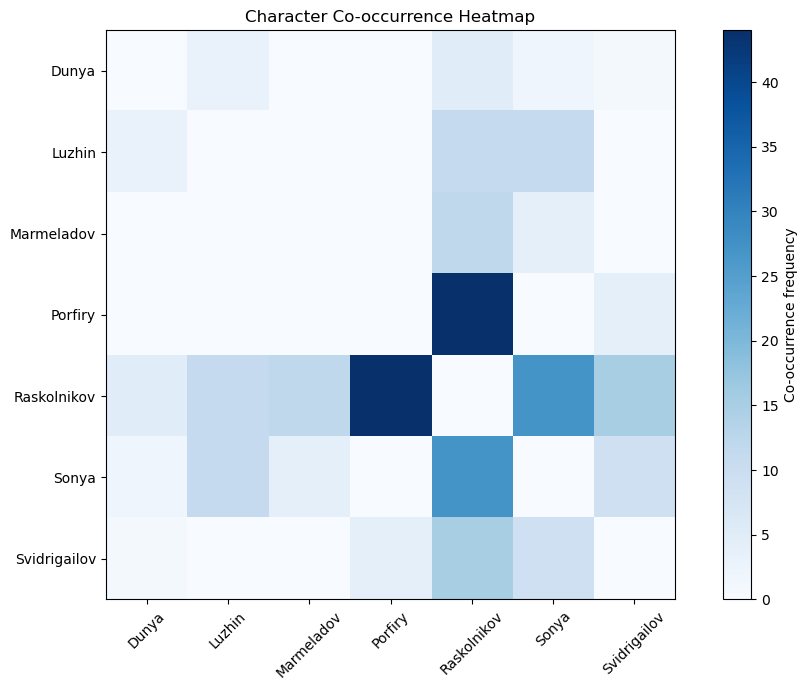

In [23]:
plt.figure(figsize=(10, 7))
plt.imshow(adj_symmetric, cmap="Blues")

plt.xticks(range(len(adj_symmetric.columns)), adj_symmetric.columns, rotation=45)
plt.yticks(range(len(adj_symmetric.index)), adj_symmetric.index)

plt.colorbar(label="Co-occurrence frequency")
plt.title("Character Co-occurrence Heatmap")
plt.tight_layout()
plt.savefig(BASE_DIR / "plots" /"cnp_relationship_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()
